<a href="https://colab.research.google.com/github/sayakpaul/vit-explain/blob/main/vit_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Imports

In [1]:
!git clone --depth 1 https://github.com/sayakpaul/vit-explain
!pip install -q timm

Cloning into 'vit-explain'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 37 (delta 1), reused 30 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.
     |████████████████████████████████| 296kB 6.5MB/s 


In [2]:
import sys
if "vit-explain" not in sys.path:
    sys.path.append("vit-explain")

import torch
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

## Define Constants

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

Using cuda


## Utilities

In [4]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

In [5]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

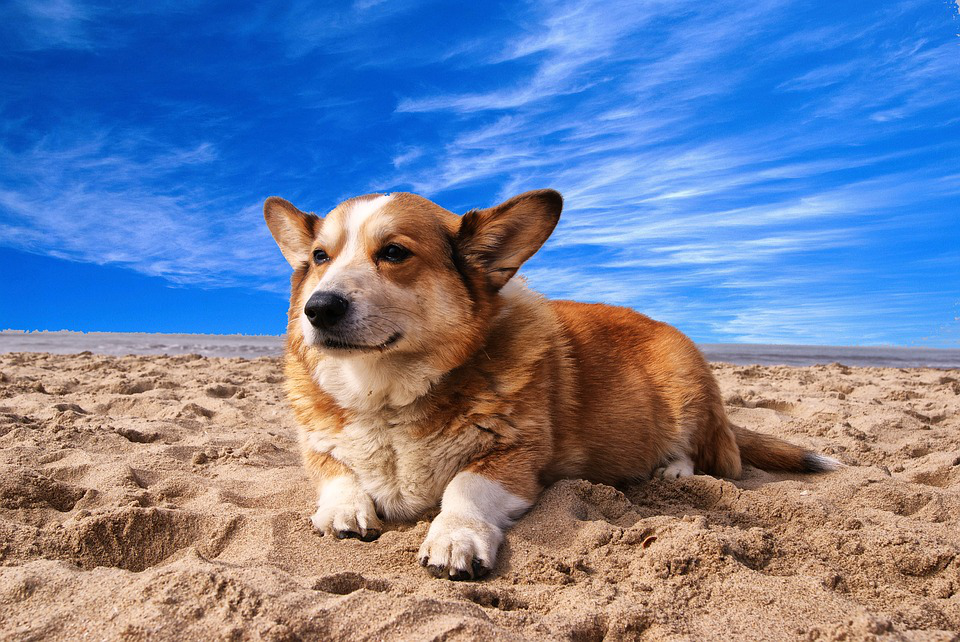

In [6]:
#@title Get an image from the internet
image_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg" #@param {type:"string"}

!wget -q {image_url} -O image.jpg
img = Image.open('image.jpg')
img

## Define augmentation transforms and load up a vision transformer

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using grad_attention_rollout


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


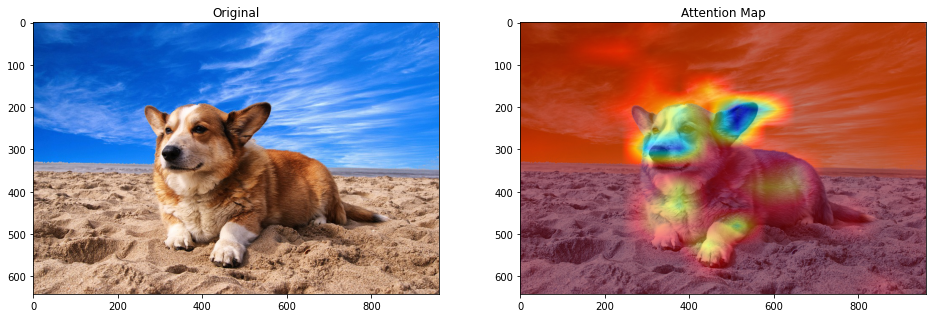

In [10]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "grad_attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("image.jpg", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)